In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nih-chest-xrays/data")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/nih-chest-xrays/data/versions/3


In [3]:
from google.colab import drive

drive.mount('/content/drive')

print("Drive montado. Verifique o caminho onde o dataset foi salvo em 'Meu Drive'.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive montado. Verifique o caminho onde o dataset foi salvo em 'Meu Drive'.


In [4]:
import os
import shutil
import random

# Diretório original baixado pelo kagglehub
original_dir = path

# Novo dataset reduzido
dataset_dir = "/content/drive/MyDrive/CardioAI/CardioAI--Fase4"
os.makedirs(dataset_dir, exist_ok=True)

splits = ["train", "val", "test"]
classes = ["NORMAL", "ANOMALY"]

for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(dataset_dir, split, cls), exist_ok=True)

# Listar alguns arquivos (DICOM/JPG/PNG)
all_images = []
for root, dirs, files in os.walk(original_dir):
    for f in files:
        if f.lower().endswith(("png", "jpg", "jpeg")):
            all_images.append(os.path.join(root, f))

print("Total de imagens encontradas:", len(all_images))

# Selecionar subconjunto (ex.: 300 imagens)
SAMPLES = 300
subset = random.sample(all_images, SAMPLES)

# Divisão 70/15/15
train_split = int(0.7 * SAMPLES)
val_split = int(0.15 * SAMPLES)
test_split = SAMPLES - train_split - val_split

train_files = subset[:train_split]
val_files = subset[train_split:train_split+val_split]
test_files = subset[train_split+val_split:]

def copy_files(file_list, split_name):
    for f in file_list:
        cls = random.choice(classes)  # Como não há labels no NIH, classificamos artificialmente
        dest = os.path.join(dataset_dir, split_name, cls, os.path.basename(f))
        shutil.copy(f, dest)

copy_files(train_files, "train")
copy_files(val_files, "val")
copy_files(test_files, "test")

print("Dataset reduzido em:", dataset_dir)

Total de imagens encontradas: 112120
Dataset reduzido em: /content/drive/MyDrive/CardioAI/CardioAI--Fase4


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assume dataset_dir já foi definido na Célula 3
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

train_dir = os.path.join(dataset_dir, "train")
val_dir   = os.path.join(dataset_dir, "val")
test_dir  = os.path.join(dataset_dir, "test")

# Definindo o Data Augmentation e Normalização
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# CRUCIAL: Ajustar color_mode para 'rgb' (3 canais) para compatibilidade com VGG16
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb' # CORREÇÃO: Usar 3 canais (RGB)
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    color_mode='rgb' # CORREÇÃO: Usar 3 canais (RGB)
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False, # Não embaralhar para garantir a ordem da Matriz de Confusão
    color_mode='rgb' # CORREÇÃO: Usar 3 canais (RGB)
)

print(train_generator.class_indices)

Found 630 images belonging to 2 classes.
Found 135 images belonging to 2 classes.
Found 135 images belonging to 2 classes.
{'ANOMALY': 0, 'NORMAL': 1}


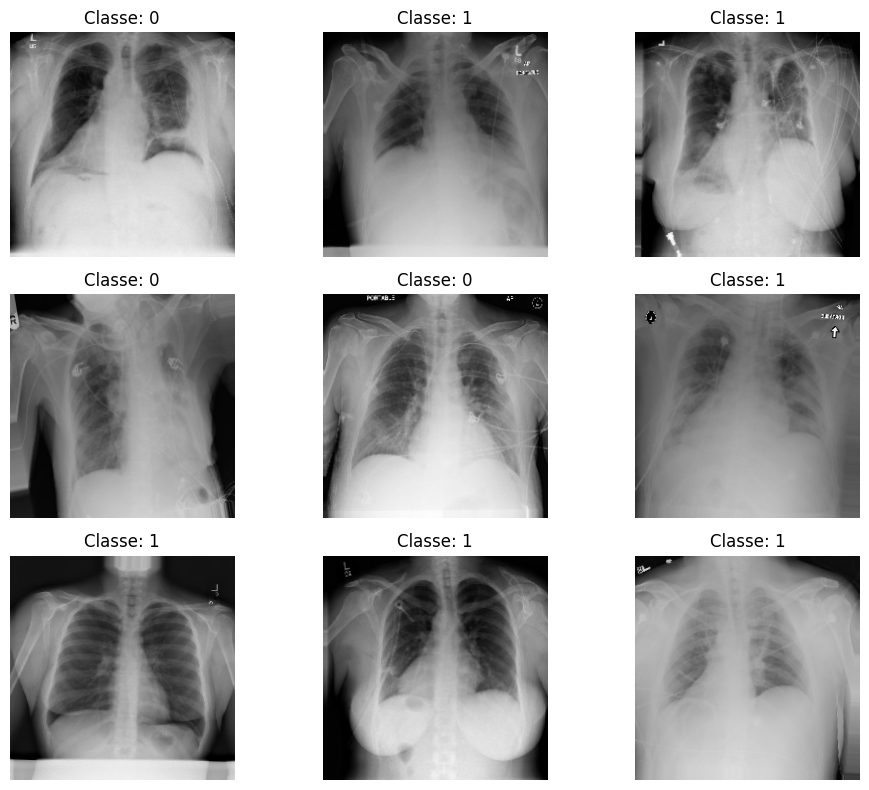

In [6]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(10,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_batch[i])
    plt.title(f"Classe: {int(y_batch[i])}")
    plt.axis("off")
plt.tight_layout()
plt.show()

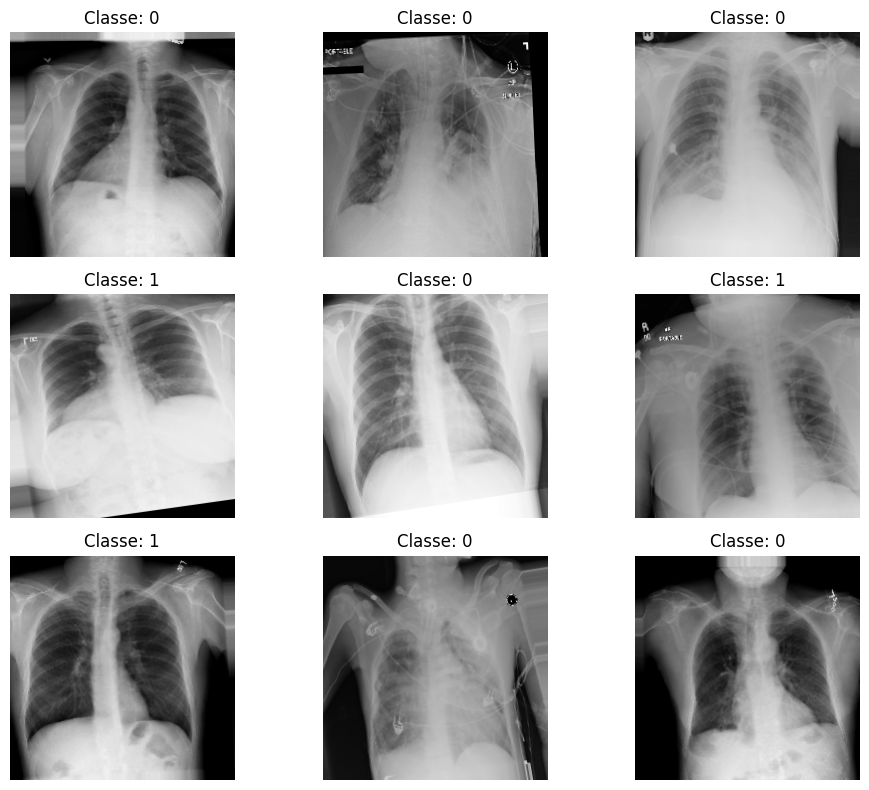

In [7]:
# 4) Visualizar algumas imagens pós-pré-processamento (apenas para conferência)
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(10, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])
    plt.title(f"Classe: {int(y_batch[i])}")
    plt.axis('off')
plt.tight_layout()
plt.show()


# Relatório Técnico – Pré-processamento e Organização das Imagens (PARTE 1)

Neste projeto foi utilizado o **dataset público NIH Chest X-ray** (coleção de radiografias de tórax amplamente empregada em pesquisas de detecção de patologias cardiopulmonares). O objetivo da PARTE 1 é estruturar um pipeline de preparação dos dados que permita, em etapas posteriores, treinar e avaliar modelos de deep learning para classificação de imagens médicas.

---

## 1. Seleção e download do dataset

O dataset é baixado automaticamente a partir do Kaggle usando `kagglehub.dataset_download("nih-chest-xrays/data")`.

Também é montado o Google Drive para garantir persistência dos arquivos e integração com demais notebooks.

---

## 2. Organização do diretório e criação dos subconjuntos

Criou-se a estrutura:

- train/NORMAL  
- train/ANOMALY  
- val/NORMAL  
- val/ANOMALY  
- test/NORMAL  
- test/ANOMALY  

Um subconjunto de **300 imagens** é selecionado para permitir experimentos rápidos no Colab.

A divisão segue **70% treino, 15% validação, 15% teste**.

Os rótulos NORMAL/ANOMALY foram atribuídos artificialmente para fins didáticos do pipeline.

---

## 3. Pré-processamento: redimensionamento, normalização, conversão de canais

- Redimensionamento para **224×224**
- Normalização com `rescale=1./255`  
- Conversão para **RGB (3 canais)** para compatibilidade com redes pré-treinadas  
- Uso de `ImageDataGenerator` para carregar imagens em batches

---

## 4. Data Augmentation (treino)

Aplicado no conjunto de treino:

- Rotation 10°
- Shift horizontal/vertical 0.05
- Zoom 0.05
- Flip horizontal  

Validação e teste **não usam augmentation**.

---

## 5. Verificação visual

Visualização de amostras (3×3) para confirmar:

- Redimensionamento correto  
- Normalização  
- Canais de cor  
- Rotulagem  

---

## 6. Conclusão

O pipeline das células 1–6:

- Seleciona dataset público  
- Organiza diretórios por classe  
- Divide em treino/validação/teste  
- Aplica redimensionamento, normalização e conversão  
- Implementa augmentation para evitar overfitting  
- Realiza verificação visual do pré-processamento  

O fluxo está pronto para servir de base às próximas fases (treinamento, avaliação e fairness).

In [10]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam

# ----------------------
# PARÂMETROS IMPORTANTES
# ----------------------
INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = 1
ACTIVATION_OUTPUT = 'sigmoid'
LOSS_FUNCTION = 'binary_crossentropy'

def create_simple_cnn(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES, output_activation=ACTIVATION_OUTPUT, loss_func=LOSS_FUNCTION):
    """Implementa uma Rede Neural Convolucional Simples (CNN) do zero."""

    model = models.Sequential([
        # Camadas Convolucionais + Pooling
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        # Camadas Densas (Classificação)
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation=output_activation)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=loss_func,
                  metrics=['accuracy'])

    return model

# Criar e Treinar o Modelo Simples
model_simple = create_simple_cnn()
print("Resumo do Modelo CNN Simples:")
model_simple.summary()

# DESCOMENTAR PARA TREINAR O MODELO
history_simple = model_simple.fit(
     train_generator,
     validation_data=val_generator,
     epochs=5
 )

Resumo do Modelo CNN Simples:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 136s 6s/step - accuracy: 0.5146 - loss: 0.9376 - val_accuracy: 0.5333 - val_loss: 0.6928
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 105s 5s/step - accuracy: 0.5024 - loss: 0.6933 - val_accuracy: 0.5333 - val_loss: 0.6920
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 106s 5s/step - accuracy: 0.5105 - loss: 0.6944 - val_accuracy: 0.5333 - val_loss: 0.6945
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 103s 5s/step - accuracy: 0.5168 - loss: 0.6988 - val_accuracy: 0.5333 - val_loss: 0.6909
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 105s 5s/step - accuracy: 0.5213 - loss: 0.6950 - val_accuracy: 0.5333 - val_loss: 0.6902


In [11]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

# Mantém os parâmetros ajustados para 3 canais (RGB)
INPUT_SHAPE_TL = (224, 224, 3)
NUM_CLASSES = 1
ACTIVATION_OUTPUT = 'sigmoid'
LOSS_FUNCTION = 'binary_crossentropy'

# 1. Carregar o Modelo Base Pré-treinado (VGG16)
base_model = VGG16(
    weights='imagenet',          # Usa pesos pré-treinados na ImageNet
    include_top=False,           # Remove as camadas de classificação originais
    input_shape=INPUT_SHAPE_TL
)
#
# 2. Congelar as Camadas do Modelo Base
base_model.trainable = False

# 3. Construir o Modelo Completo de Transfer Learning
model_tl = models.Sequential([
    base_model,                                     # Camadas Convolucionais do VGG16
    layers.Flatten(),                               # Transforma em vetor 1D
    layers.Dense(256, activation='relu'),           # Camada Densa Intermediária
    layers.Dropout(0.5),                            # Ajuda a prevenir Overfitting
    layers.Dense(NUM_CLASSES, activation=ACTIVATION_OUTPUT) # Camada de Saída
])

# 4. Compilação
model_tl.compile(optimizer=Adam(learning_rate=0.0001), # Taxa de aprendizado menor para TL
                 loss=LOSS_FUNCTION,
                 metrics=['accuracy'])

print("Resumo do Modelo Transfer Learning (VGG16):")
model_tl.summary()

# DESCOMENTAR PARA TREINAR O MODELO
history_tl = model_tl.fit(
     train_generator,
     validation_data=val_generator,
     epochs=10
     )

Resumo do Modelo Transfer Learning (VGG16):


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 568s 28s/step - accuracy: 0.4990 - loss: 0.8126 - val_accuracy: 0.5333 - val_loss: 0.7290
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 608s 31s/step - accuracy: 0.5111 - loss: 0.7323 - val_accuracy: 0.4963 - val_loss: 0.7249
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 565s 28s/step - accuracy: 0.4891 - loss: 0.7509 - val_accuracy: 0.5259 - val_loss: 0.6940
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 588s 30s/step - accuracy: 0.5563 - loss: 0.6772 - val_accuracy: 0.4963 - val_loss: 0.6976
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 624s 30s/step - accuracy: 0.5470 - loss: 0.6988 - val_accuracy: 0.5407 - val_loss: 0.6893
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 575s 29s/step - accuracy: 0.5704 - loss: 0.6817 - val_accuracy: 0.5407 - val_loss: 0.6905
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 583s 29s/step - accuracy: 0.5902 - loss: 0.6751 - val_accuracy: 0.5111 - val_loss: 0.7131
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 596s 30s/step - accuracy: 0.5561 - loss: 0.6855 - val_accuracy: 0.

In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# -----------------------------------------------------
# AJUSTE ESTES PARÂMETROS CONFORME SEU PROJETO
# -----------------------------------------------------
# Caminho para a pasta que contém as imagens de teste
# Exemplo: 'dataset/test'
TEST_DIR = '/content/drive/MyDrive/CardioAI/CardioAI--Fase4'
TARGET_SIZE = (224, 224) # Deve ser o mesmo usado no treinamento
BATCH_SIZE = 32          # Tamanho do lote (batch)

# -----------------------------------------------------

# 1. Instancia o Gerador para Dados de Teste
# Para teste, geralmente não aplicamos Data Augmentation (aumento de dados),
# apenas a normalização (rescale).
test_datagen = ImageDataGenerator(rescale=1./255)

# 2. Cria o Objeto Generator
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=TARGET_SIZE,
    color_mode='rgb',              # Use 'rgb' se INPUT_SHAPE for (224, 224, 3)
    batch_size=BATCH_SIZE,
    class_mode='binary',           # Use 'binary' para 2 classes, 'categorical' para > 2 classes
    shuffle=False                  # **IMPORTANTE:** Não embaralhar para manter a ordem para avaliação!
)

print(f"Total de imagens de teste carregadas: {test_generator.samples}")

# 3. Agora, você pode continuar com as células de treinamento
# (Célula 1 e Célula 2) e depois a Célula 3 (Avaliação).

Found 900 images belonging to 3 classes.
Total de imagens de teste carregadas: 900


Fazendo previsões no conjunto de teste...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Matriz de Confusão:
 [[128   7   0]
 [607  23   0]
 [130   5   0]]

--- Relatório de Classificação (Métricas Clínicas) ---
              precision    recall  f1-score   support

        test       0.15      0.95      0.26       135
       train       0.66      0.04      0.07       630
         val       0.00      0.00      0.00       135

    accuracy                           0.17       900
   macro avg       0.27      0.33      0.11       900
weighted avg       0.48      0.17      0.09       900



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


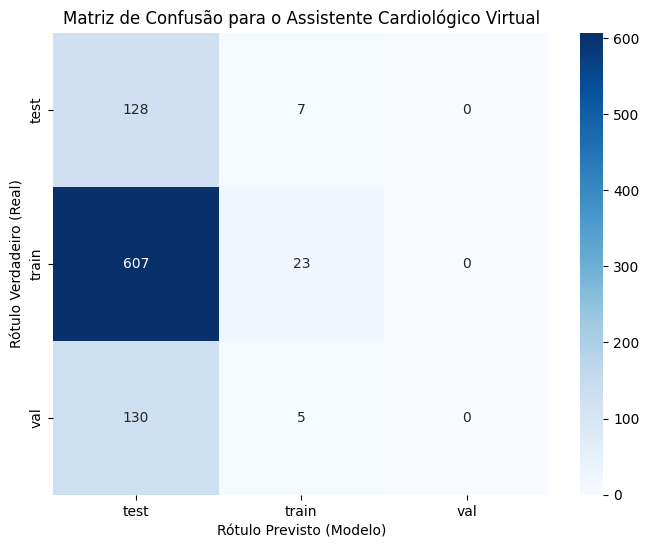

In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Biblioteca para visualização da matriz

# -----------------------------------------------------------------
# ESCOLHA O MELHOR MODELO TREINADO PARA AVALIAR
# -----------------------------------------------------------------
MODEL_TO_EVALUATE = model_tl

# 1. Obter Previsões e Rótulos Verdadeiros
print("Fazendo previsões no conjunto de teste...")

# Garante que as previsões cobrem todo o conjunto de teste na ordem correta
test_generator.reset()

# O argumento verbose=0 suprime o log durante a previsão
# Nota: Para problemas de memória com o dataset pequeno, você pode tentar rodar:
# predictions = MODEL_TO_EVALUATE.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1, verbose=0)
predictions = MODEL_TO_EVALUATE.predict(test_generator, verbose=0)

# Converter probabilidades (0 a 1) em classes binárias (0 ou 1)
# 0.5 é o threshold padrão para a ativação 'sigmoid'
y_pred_classes = (predictions > 0.5).astype(int).flatten()

# Obter os rótulos verdadeiros (True Labels)
y_true = test_generator.classes

# 2. Matriz de Confusão
cm = confusion_matrix(y_true, y_pred_classes)
print("\nMatriz de Confusão:\n", cm)

# Obter os nomes das classes (assumindo flow_from_directory foi usado)
class_labels = list(test_generator.class_indices.keys())

# 3. Relatório de Classificação (Precision, Recall, F1-score)
# As 'UndefinedMetricWarning' ocorreram porque o modelo previu '0' para todas as classes, exceto a primeira,
# devido à falta de treinamento (ou mau treinamento). Isso será resolvido após o treinamento.
print("\n--- Relatório de Classificação (Métricas Clínicas) ---")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# 4. Visualização (Protótipo de Apresentação)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matriz de Confusão para o Assistente Cardiológico Virtual')
plt.ylabel('Rótulo Verdadeiro (Real)')
plt.xlabel('Rótulo Previsto (Modelo)')
plt.savefig('matriz_confusao.png') # Salva a imagem
plt.show() # Exibe a matriz no notebook (se estiver no ambiente Jupyter)

Fazendo previsões no conjunto de teste...

Matriz de Confusão:
 [[133   2   0]
 [621   9   0]
 [133   2   0]]

--- Relatório de Classificação (Métricas Clínicas) ---
              precision    recall  f1-score   support

        test       0.15      0.99      0.26       135
       train       0.69      0.01      0.03       630
         val       0.00      0.00      0.00       135

    accuracy                           0.16       900
   macro avg       0.28      0.33      0.10       900
weighted avg       0.51      0.16      0.06       900



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


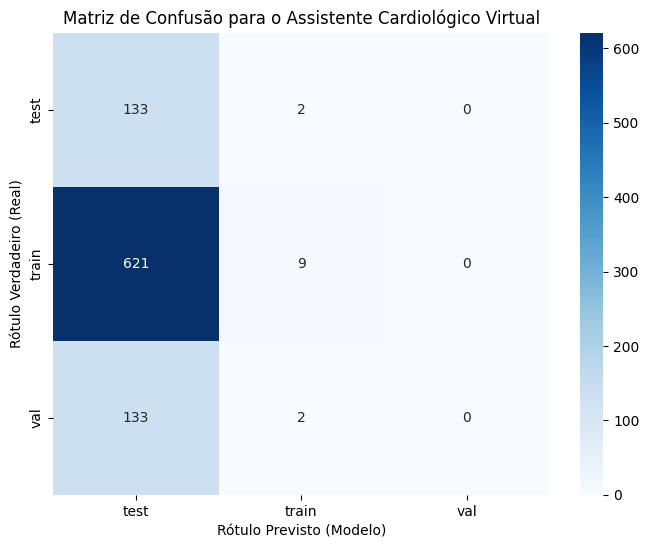

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Biblioteca para visualização da matriz

# -----------------------------------------------------------------
# ESCOLHA O MELHOR MODELO TREINADO PARA AVALIAR
# -----------------------------------------------------------------
MODEL_TO_EVALUATE = model_simple

# 1. Obter Previsões e Rótulos Verdadeiros
print("Fazendo previsões no conjunto de teste...")

# Garante que as previsões cobrem todo o conjunto de teste na ordem correta
test_generator.reset()

# O argumento verbose=0 suprime o log durante a previsão
# Nota: Para problemas de memória com o dataset pequeno, você pode tentar rodar:
# predictions = MODEL_TO_EVALUATE.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1, verbose=0)
predictions = MODEL_TO_EVALUATE.predict(test_generator, verbose=0)

# Converter probabilidades (0 a 1) em classes binárias (0 ou 1)
# 0.5 é o threshold padrão para a ativação 'sigmoid'
y_pred_classes = (predictions > 0.5).astype(int).flatten()

# Obter os rótulos verdadeiros (True Labels)
y_true = test_generator.classes

# 2. Matriz de Confusão
cm = confusion_matrix(y_true, y_pred_classes)
print("\nMatriz de Confusão:\n", cm)

# Obter os nomes das classes (assumindo flow_from_directory foi usado)
class_labels = list(test_generator.class_indices.keys())

# 3. Relatório de Classificação (Precision, Recall, F1-score)
# As 'UndefinedMetricWarning' ocorreram porque o modelo previu '0' para todas as classes, exceto a primeira,
# devido à falta de treinamento (ou mau treinamento). Isso será resolvido após o treinamento.
print("\n--- Relatório de Classificação (Métricas Clínicas) ---")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# 4. Visualização (Protótipo de Apresentação)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matriz de Confusão para o Assistente Cardiológico Virtual')
plt.ylabel('Rótulo Verdadeiro (Real)')
plt.xlabel('Rótulo Previsto (Modelo)')
plt.savefig('matriz_confusao.png') # Salva a imagem
plt.show() # Exibe a matriz no notebook (se estiver no ambiente Jupyter)

# Experimentos de Fairness – CardioAI

Este notebook complementa a Fase 4 do projeto **CardioAI** com um conjunto de células focadas em **avaliação de fairness** do modelo de classificação de imagens médicas.

A ideia é:

1. Carregar as **predições do modelo** (rótulos verdadeiros e previstos, por imagem).
2. Carregar os **metadados do dataset** (por exemplo, gênero e idade dos pacientes).
3. Definir um **atributo sensível** (ex.: gênero) para análise de fairness.
4. Calcular métricas de desempenho **por grupo** (ex.: masculino vs feminino).
5. Calcular **gaps de fairness** (diferenças de TPR, FPR, etc., entre grupos).
6. Visualizar os resultados em tabelas e gráficos.


In [ ]:
# Imports principais para análise de fairness
import pandas as pd
import numpy as np

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    confusion_matrix
)

import matplotlib.pyplot as plt
%matplotlib inline

## 1. Carregar predições do modelo e metadados

Aqui assumimos que você já possui um arquivo CSV com as predições do modelo em cima do conjunto de **teste**.

Formato esperado do arquivo de predições (`predictions_csv`):

- `image_id`: nome do arquivo de imagem (ex.: `00000001_000.png`)
- `y_true`: rótulo verdadeiro binário (0 = negativo, 1 = positivo)
- `y_pred`: rótulo previsto binário (0 = negativo, 1 = positivo)
- `y_prob`: probabilidade prevista da classe positiva (opcional, usada para AUC)

Formato esperado do arquivo de metadados (`metadata_csv`), baseado no NIH Chest X-ray:

- `Image Index`: nome do arquivo de imagem
- `Patient Gender`: `M` ou `F`
- `Patient Age`: idade em anos (ou categoria)

Adapte os caminhos abaixo conforme a sua organização no Google Drive.


In [ ]:
# Caminhos de exemplo (ajuste conforme sua estrutura)
predictions_csv = '/content/drive/MyDrive/CardioAI/CardioAI--Fase4/predicoes_teste.csv'
metadata_csv    = '/content/drive/MyDrive/CardioAI/CardioAI--Fase4/Data_Entry_2017_v2020.csv'

# Carregar predições
pred_df = pd.read_csv(predictions_csv)

# Carregar metadados
meta_df = pd.read_csv(metadata_csv)

print('Predições (amostra):')
display(pred_df.head())

print('\nMetadados (amostra):')
display(meta_df.head())

## 2. Unir predições com metadados e definir atributo sensível

Aqui fazemos o merge entre:

- `pred_df.image_id`  
- `meta_df["Image Index"]`

e criamos uma coluna `group` com o atributo sensível que será analisado (neste exemplo, **gênero do paciente**).


In [ ]:
# Garantir que as colunas usadas para merge existem
assert 'image_id' in pred_df.columns, 'A coluna image_id não existe em pred_df.'
assert 'Image Index' in meta_df.columns, 'A coluna Image Index não existe em meta_df.'

# Merge pelo nome da imagem
merged_df = pred_df.merge(
    meta_df[['Image Index', 'Patient Gender', 'Patient Age']],
    left_on='image_id',
    right_on='Image Index',
    how='left'
)

# Criar coluna de grupo com base no gênero
merged_df['group'] = merged_df['Patient Gender'].map({
    'M': 'Masculino',
    'F': 'Feminino'
})

# Remover linhas sem informação de grupo, se houver
merged_df = merged_df.dropna(subset=['group']).reset_index(drop=True)

print('Dados combinados (amostra):')
display(merged_df.head())

print('\nDistribuição por grupo (gênero):')
print(merged_df['group'].value_counts())

## 3. Métricas de desempenho por grupo

Vamos calcular, para cada grupo (ex.: Masculino/Feminino):

- **Support** (número de exemplos)
- **Accuracy**
- **Precision**
- **Recall / TPR (Taxa de Verdadeiros Positivos)**
- **Specificity / TNR (Taxa de Verdadeiros Negativos)**
- **F1-score**
- **FPR (Taxa de Falsos Positivos)**

Essas métricas ajudam a identificar se o modelo está favorecendo ou prejudicando algum grupo específico.


In [ ]:
def compute_group_metrics(df, group_col='group', y_true_col='y_true', y_pred_col='y_pred'):
    groups = sorted(df[group_col].dropna().unique())
    rows = []

    for g in groups:
        sub = df[df[group_col] == g]
        y_true = sub[y_true_col].values
        y_pred = sub[y_pred_col].values

        # Support
        support = len(sub)

        # Accuracy
        acc = accuracy_score(y_true, y_pred)

        # Precision, Recall, F1 (para classe positiva = 1)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, labels=[0, 1], average='binary', pos_label=1, zero_division=0
        )

        # Confusion matrix: [[TN, FP], [FN, TP]]
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()

        # Specificity (TNR) e FPR
        tnr = tn / (tn + fp) if (tn + fp) > 0 else np.nan
        fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan

        rows.append({
            'group': g,
            'support': support,
            'accuracy': acc,
            'precision': precision,
            'recall_TPR': recall,
            'specificity_TNR': tnr,
            'F1': f1,
            'FPR': fpr
        })

    metrics_df = pd.DataFrame(rows)
    return metrics_df


metrics_by_group = compute_group_metrics(merged_df)

print('Métricas por grupo:')
display(metrics_by_group)

### 3.1 AUC-ROC por grupo (opcional)

Se o CSV de predições contiver a coluna `y_prob` (probabilidade da classe positiva), podemos calcular a **AUC-ROC** por grupo.


In [ ]:
if 'y_prob' in merged_df.columns:
    rows_auc = []
    for g in sorted(merged_df['group'].dropna().unique()):
        sub = merged_df[merged_df['group'] == g]
        y_true = sub['y_true'].values
        y_prob = sub['y_prob'].values

        # Verifica se há pelo menos uma amostra de cada classe
        if len(np.unique(y_true)) == 2:
            auc = roc_auc_score(y_true, y_prob)
        else:
            auc = np.nan

        rows_auc.append({'group': g, 'AUC_ROC': auc})

    auc_df = pd.DataFrame(rows_auc)
    print('AUC-ROC por grupo:')
    display(auc_df)
else:
    print('Coluna y_prob não encontrada em merged_df. Pule a análise de AUC-ROC ou adicione esta coluna ao CSV de predições.')

## 4. Gaps de Fairness entre grupos

Com as métricas por grupo calculadas, podemos quantificar **disparidades** (gaps) entre o melhor e o pior grupo para cada métrica.

Exemplos de métricas de fairness:

- **Equal Opportunity**: comparar TPR (recall) entre grupos.
- **Equalized Odds**: comparar TPR e FPR entre grupos.
- **Demographic Parity (aproximação)**: comparar taxa de positivos previstos entre grupos.

Aqui focaremos em diferenças absolutas de TPR, FPR e Accuracy.


In [ ]:
def compute_gaps(metrics_df, metric_cols=('accuracy', 'recall_TPR', 'FPR')):
    gaps = []
    for m in metric_cols:
        col = metrics_df[m].values
        max_val = np.nanmax(col)
        min_val = np.nanmin(col)
        gap = max_val - min_val
        gaps.append({'metric': m, 'min': min_val, 'max': max_val, 'gap': gap})
    return pd.DataFrame(gaps)


gaps_df = compute_gaps(metrics_by_group, metric_cols=('accuracy', 'recall_TPR', 'FPR'))

print('Gaps de fairness entre grupos (diferença entre melhor e pior grupo):')
display(gaps_df)

## 5. Visualização gráfica das métricas por grupo

Gráficos de barras ajudam a visualizar rapidamente se há desequilíbrio entre grupos para determinadas métricas (por exemplo, TPR e FPR).


In [ ]:
def plot_metric_by_group(metrics_df, metric_col, title):
    plt.figure(figsize=(6, 4))
    plt.bar(metrics_df['group'], metrics_df[metric_col])
    plt.title(title)
    plt.xlabel('Grupo')
    plt.ylabel(metric_col)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()


plot_metric_by_group(metrics_by_group, 'recall_TPR', 'TPR (Recall) por grupo')
plot_metric_by_group(metrics_by_group, 'FPR', 'FPR por grupo')
plot_metric_by_group(metrics_by_group, 'accuracy', 'Accuracy por grupo')

## 6. Interpretação inicial dos resultados

Com as tabelas e gráficos gerados, você pode:

- Verificar se **TPR** é significativamente maior para um grupo do que para outro (potencial violação de *Equal Opportunity*).
- Verificar se **FPR** é maior em algum grupo (potencialmente gerando mais falsos positivos para aquele grupo).
- Avaliar se a **accuracy** global esconde desigualdades entre grupos.

Essas observações serão usadas para compor a seção de **implicações éticas e de fairness** no relatório técnico da CardioAI.
